#**Set up the environment**

In [ ]:
import os
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
from tables import * # needed to read .h5 files
import math
import seaborn as sns
from scipy import ndimage
from tensorflow import keras

from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate,Conv3D, MaxPooling3D,Input, BatchNormalization,UpSampling3D,Reshape


from keras import backend as K
from keras import optimizers

from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from datetime import datetime
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import datetime
import pandas as pd
import random
import h5py

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
root = '/content/gdrive/MyDrive/Neuroengineering'
os.makedirs(root, exist_ok=True)

#**Load dataset**

#### hdf files includes a series of formats created to organize and store a large quantity of data

In [ ]:
# METHOD A: importing .h5 files
h5file = open_file("/content/gdrive/MyDrive/New_data/FPreductionDataset_v3.h5", mode = "r")

OSError: ignored

In [ ]:
# Show target variable
y = np.array(h5file.root.target)
print(y)
print(len(y))

[0 0 0 ... 1 1 1]
7161


## Plotting the distributions of the two classes

In [ ]:
class_zero = len(np.where(y==0)[0])
class_one = len(np.where(y==1)[0])
print(('The number of FP is equal to: {}').format(str(class_zero)))
print(('The number of TP is equal to: {}').format(str(class_one)))

The number of FP is equal to: 6082
The number of TP is equal to: 1079


In [ ]:
graph = os.path.join(root, 'graph_notes')
os.makedirs(graph, exist_ok=True)

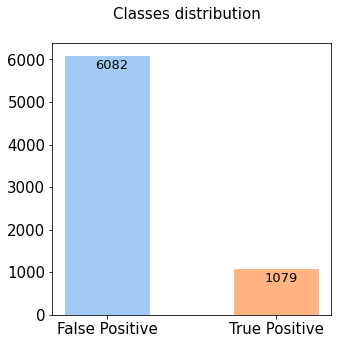

In [ ]:
# PLOT THE DISTRIBUTION OF THE TWO CLASSES
names = ['False Positive', 'True Positive']
values = [class_zero, class_one]

fig = plt.figure(figsize=(5, 5))
fig.suptitle('Classes distribution', fontsize = 15)

ax = fig.add_subplot(1, 1, 1) 
y_pos = [1,1.5]
plt.bar(y_pos, values, color=sns.color_palette('pastel'),width=0.25)
for index, value in enumerate(y_pos):
    plt.text(value-0.035, values[index]-300, str(values[index]), #color = 'black', fontsize=10)
     fontsize=13)
plt.xticks(y_pos, names, fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()
fig.savefig(os.path.join(graph, 'Classes distribution'), facecolor=fig.get_facecolor())

## Visualization of image patches

In [ ]:
IDX_class_zero = np.where(y==0)[0]
IDX_class_one = np.where(y==1)[0]

In [ ]:
def normalize(x_img):
    MIN_BOUND = -1200.0
    MAX_BOUND = 600.0
    PIXEL_MEAN = 0.12 #0.25 
    PIXEL_CORR = int((MAX_BOUND - MIN_BOUND) * PIXEL_MEAN) # in this case, 350
    x_img -= PIXEL_CORR # centering
    x_img[x_img>MAX_BOUND] = MAX_BOUND # clipping
    x_img[x_img<MIN_BOUND] = MIN_BOUND # scaling
    x_img = ((x_img - (MIN_BOUND)) / (MAX_BOUND - (MIN_BOUND)))
    
    return x_img

5088
4047
501
2465
6907
4693
5383
2884
6434
3429


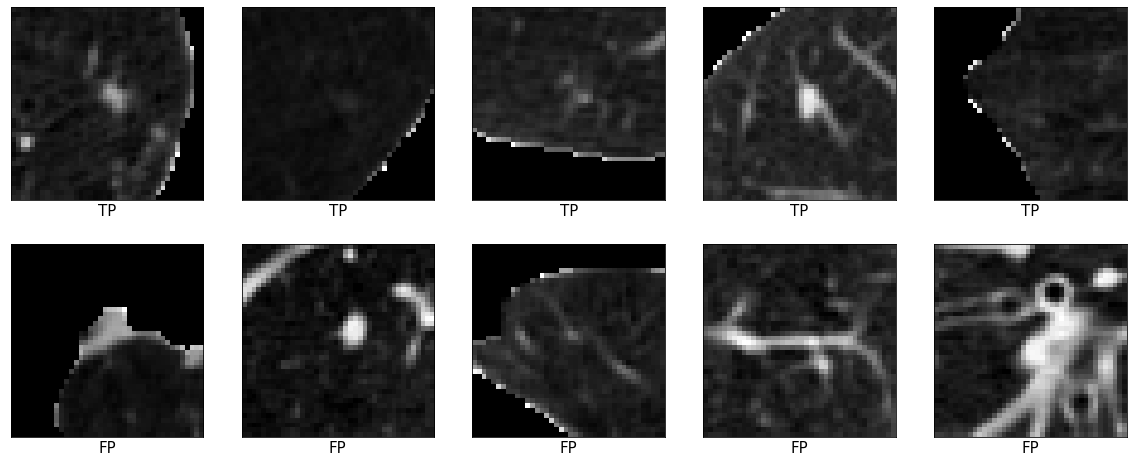

In [ ]:
# Display examples of the dataset
plt.figure(figsize=(20,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    TPidx = random.randrange(len(IDX_class_one))
    image = normalize(h5file.root.images[IDX_class_one[TPidx],12,:,:])  # extraction of the central slice of the volumetric patch 26x48x48. 
    plt.imshow(image,cmap='gray')
    plt.xlabel('TP', fontsize = 15)
    plt.xticks([])
    plt.yticks([])
    print(IDX_class_one[TPidx])
    plt.subplot(2,5,i+6)
    FPidx = random.randrange(len(IDX_class_zero))
    image = normalize(h5file.root.images[IDX_class_zero[FPidx],12,:,:])  # extraction of the central slice of the volumetric patch 26x48x48. 
    plt.imshow(image,cmap='gray')
    plt.xlabel('FP', fontsize = 15)
    plt.xticks([])
    plt.yticks([])
    print(IDX_class_zero[FPidx])

(40, 40)

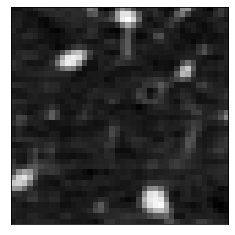

In [ ]:
image = normalize(h5file.root.images[IDX_class_zero[FPidx],23,:,:]) 
plt.imshow(image,cmap='gray')
plt.xticks([])
plt.yticks([])
np.shape(image)

##**Split the dataset**

In [ ]:
ptIDall =  h5file.root.anonID[0:]
print(len(ptIDall))
ptUnique =  list(set(ptIDall))

print(" The total number of patients in the dataset is equal to = {}".format(len(ptUnique)))
print(ptUnique)
random.seed(4)
random.shuffle(ptUnique)

ptIDall =  h5file.root.anonID[0:]

ptUnique =  list(set(ptIDall))

random.seed(4)
random.shuffle(ptUnique)

Ntr = int(len(ptUnique)*0.60)

print(" Il numero totale di pazienti nel training set è = {}".format(Ntr))
Nval = int(len(ptUnique)*0.20)
print(" Il numero totale di pazienti nel validation set è = {}".format(Nval))
Nte = len(ptUnique)-Ntr-Nval
print(" Il numero totale di pazienti nel test set è = {}".format(Nte))
ptTrain = ptUnique[0:Ntr]

ptVal = ptUnique[Ntr:Ntr+Nval]
ptTest = ptUnique[Ntr+Nval:]

idx_train = np.where(np.isin(ptIDall,ptTrain))[0]
idx_val = np.where(np.isin(ptIDall,ptVal))[0]
idx_test = np.where(np.isin(ptIDall,ptTest))[0]
print(len(idx_train))
print(len(idx_val))
print(len(idx_test))



7161
 The total number of patients in the dataset is equal to = 81
[5125, 4103, 8, 9, 11, 24, 31, 32, 35, 4651, 558, 55, 571, 1596, 3137, 578, 67, 70, 74, 77, 5197, 80, 4176, 83, 84, 3158, 599, 88, 600, 91, 1121, 4196, 614, 1129, 620, 646, 4742, 4745, 141, 1165, 3740, 180, 3257, 698, 703, 4800, 711, 726, 738, 3820, 1778, 4339, 253, 255, 2819, 3844, 261, 4361, 272, 4368, 3872, 290, 824, 4933, 854, 1379, 3946, 365, 373, 890, 384, 4487, 923, 1960, 4528, 456, 4558, 1491, 1516, 2542, 4084]
 Il numero totale di pazienti nel training set è = 48
 Il numero totale di pazienti nel validation set è = 16
 Il numero totale di pazienti nel test set è = 17
3626
1524
2011


In [ ]:
y = np.array(h5file.root.target)
y_train = y[idx_train]
print(np.shape(y_train))
print(y_train)

train_zero = len(np.where(y[idx_train]==0)[0])
train_one = len(np.where(y[idx_train]==1)[0])
print('N = {} samples labelled as 0 in training set'.format(len(np.where(y[idx_train]==0)[0])))
print('N = {} samples labelled as 1 in training set'.format(len(np.where(y[idx_train]==1)[0])))

validation_zero = len(np.where(y[idx_val]==0)[0])
validation_one = len(np.where(y[idx_val]==1)[0])
print('N = {} samples labelled as 0 in validation set'.format(len(np.where(y[idx_val]==0)[0])))
print('N = {} samples labelled as 1 in validation set'.format(len(np.where(y[idx_val]==1)[0])))

test_zero = len(np.where(y[idx_test]==0)[0])
test_one = len(np.where(y[idx_test]==1)[0])
print('N = {} samples labelled as 0 in test set'.format(len(np.where(y[idx_test]==0)[0])))
print('N = {} samples labelled as 1 in test set'.format(len(np.where(y[idx_test]==1)[0])))

print('The training set has {} samples'.format(len(idx_train)))
print('The validation set has {} samples'.format(len(idx_val)))
print('The test set has {} samples!'.format(len(idx_test)))

percentage_training = len(idx_train)*100/len(y)
percentage_validation = len(idx_val)*100/len(y)
percentage_test = len(idx_test)*100/len(y)

print('The training set is the {}% of the dataset samples'.format(percentage_training))
print('The validation set is the {}% of the dataset samples'.format(percentage_validation))
print('The test set is the {}% of the dataset samples'.format(percentage_test))


# CREATE THE VECTOR OF TARGETS:
# If we are using a softmax function in the output layer, we need to create a two column vector where
# the first column corresponds to the probability of being 1 while the second to the probability of being 0 
y = np.transpose(np.array([y,(1-y)]))
print(('The new shape of the target vector is {}').format(np.shape(y)))

# 0 = FP
# 1 = TP
print(y)


(3626,)
[1 0 0 ... 0 0 1]
N = 3001 samples labelled as 0 in training set
N = 625 samples labelled as 1 in training set
N = 1326 samples labelled as 0 in validation set
N = 198 samples labelled as 1 in validation set
N = 1755 samples labelled as 0 in test set
N = 256 samples labelled as 1 in test set
The training set has 3626 samples
The validation set has 1524 samples
The test set has 2011 samples!
The training set is the 50.635386119257085% of the dataset samples
The validation set is the 21.281943862589024% of the dataset samples
The test set is the 28.082670018153888% of the dataset samples
The new shape of the target vector is (7161, 2)
[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


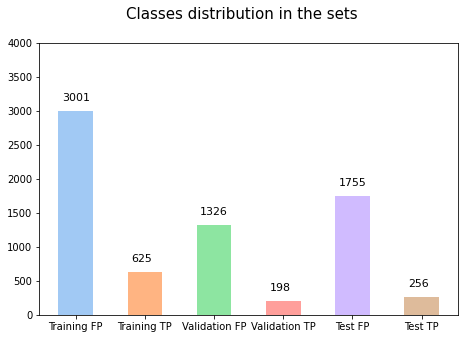

In [ ]:
# CLASSES DISTRIBUTION IN TRAINING AND VALIDATION

names = ['Training FP', 'Training TP', 'Validation FP', 'Validation TP', 'Test FP', 'Test TP']
values = [train_zero, train_one, validation_zero, validation_one, test_zero, test_one]


fig = plt.figure(figsize=(7.5, 5))
fig.suptitle('Classes distribution in the sets', fontsize = 15)
#fig.set_facecolor('xkcd:dark grey')
ax = fig.add_subplot(1, 1, 1) 
#ax.set_facecolor('xkcd:black')
ax.set_ylim([0,4000])
y_pos = [1,1.5,2,2.5, 3, 3.5]
for index, value in enumerate(y_pos):
    plt.text(value-0.1, values[index]+150, str(values[index]), fontsize=11)
plt.bar(y_pos, values, color=sns.color_palette('pastel'),width=0.25)
plt.xticks(y_pos, names )
#plt.yticks( color = 'white' )
plt.show
fig.savefig(os.path.join(graph, 'Classes distribution in the sets_1'), facecolor=fig.get_facecolor())

In [ ]:
print(train_zero)
print(train_one)

3001
625


In [ ]:
print(validation_zero)
print(validation_one)

1326
198


In [ ]:
print(test_zero)
print(test_one)

1755
256


#**Model architecture definition**

In [ ]:
# Build the model
# ARCH_1
#we need to design the mode based on the model of the paper: DOU
input_layer1 = keras.layers.Input(shape = (6,20,20,1))

C1 = tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(input_layer1)


M1 =  tf.keras.layers.MaxPooling3D( pool_size= (1,2,2),
                                  padding="same"
                                )(C1)

C2 =  tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(M1)

M2 =  tf.keras.layers.MaxPooling3D( pool_size= (2,2,2),
                                  padding="same"
                                )(C2)
                                
C3 =  tf.keras.layers.Conv3D( filters=32,
                              kernel_size=(3,5,5),
                              padding="same",
                              activation="relu")(M2)

F0 = tf.keras.layers.Flatten()(C3)

DP1 = tf.keras.layers.Dropout(0.2)(F0)

FC1 =  tf.keras.layers.Dense(units =64,
                          activation = 'relu',
                          use_bias = True)(DP1)

DP2 = tf.keras.layers.Dropout(0.3)(FC1)

FC2 =  tf.keras.layers.Dense(units = 64,
                          activation = 'relu',
                          use_bias = True)(DP2)

DP3 = tf.keras.layers.Dropout(0.4)(FC2)

output_layer1 = tf.keras.layers.Dense( units = 2, activation="softmax")(DP3)

In [ ]:
model1 = keras.Model(inputs=input_layer1,
                    outputs=output_layer1,
                    name="ARCH_1_model")

In [ ]:
model1.summary()

Model: "ARCH_1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 20, 20, 1)]    0         
                                                                 
 conv3d (Conv3D)             (None, 6, 20, 20, 32)     2432      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 10, 10, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 10, 10, 32)     76832     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 5, 5, 32)      0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 5, 5, 32)      

In [ ]:
# Build the model
#ARCH_2
#we need to design the mode based on the model of the paper 
input_layer2 = tf.keras.layers.Input(shape = (10,30,30,1))

C1 = tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(input_layer2)


M1 =  tf.keras.layers.MaxPooling3D( pool_size= (1,2,2),
                                  padding="same"
                                )(C1)

C2 =  tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(M1)

M2 =  tf.keras.layers.MaxPooling3D( pool_size= (2,2,2),
                                  padding="same"
                                )(C2)
                                
C3 =  tf.keras.layers.Conv3D( filters=32,
                              kernel_size=(3,5,5),
                              padding="same",
                              activation="relu")(M2)

M3 =  tf.keras.layers.MaxPooling3D( pool_size= (1,2,2),
                                  padding="same"
                                )(C3)

F0 = tf.keras.layers.Flatten()(M3)

DP1 = tf.keras.layers.Dropout(0.2)(F0)

FC1 =  tf.keras.layers.Dense(units =64,
                          activation = 'relu',
                          use_bias = True)(DP1)

DP2 = tf.keras.layers.Dropout(0.3)(FC1)

FC2 =  tf.keras.layers.Dense(units = 64,
                          activation = 'relu',
                          use_bias = True)(DP2)

DP3 = tf.keras.layers.Dropout(0.4)(FC2)

output_layer2 = tf.keras.layers.Dense( units = 2, activation="softmax")(DP3)



In [ ]:
model2 = keras.Model(inputs=input_layer2,
                    outputs=output_layer2,
                    name="ARCH_2_model")

In [ ]:
model2.summary()

Model: "ARCH_2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 30, 30, 1)]   0         
                                                                 
 conv3d_3 (Conv3D)           (None, 10, 30, 30, 32)    2432      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 10, 15, 15, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 15, 15, 32)    76832     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 8, 8, 32)      0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 5, 8, 8, 32)      

In [ ]:
# Build the model
#ARCH_3
input_layer3 = tf.keras.layers.Input(shape = (26,40,40,1))

C1 = tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(input_layer3)


M1 =  tf.keras.layers.MaxPooling3D( pool_size= (1,2,2),
                                  padding="same"
                                )(C1)

C2 =  tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(M1)

M2 =  tf.keras.layers.MaxPooling3D( pool_size= (2,2,2),
                                  padding="same"
                                )(C2)
                                
C3 =  tf.keras.layers.Conv3D( filters=32,
                              kernel_size=(3,5,5),
                              padding="same",
                              activation="relu")(M2)

M3 =  tf.keras.layers.MaxPooling3D( pool_size= (2,2,2),
                                  padding="same"
                                )(C3)

F0 = tf.keras.layers.Flatten()(M3)

DP1 = tf.keras.layers.Dropout(0.2)(F0)

FC1 =  tf.keras.layers.Dense(units =64,
                          activation = 'relu',
                          use_bias = True)(DP1)

DP2 = tf.keras.layers.Dropout(0.3)(FC1)

FC2 =  tf.keras.layers.Dense(units = 64,
                          activation = 'relu',
                          use_bias = True)(DP2)

DP2 = tf.keras.layers.Dropout(0.4)(FC2)

output_layer3 = tf.keras.layers.Dense( units = 2, activation="softmax")(DP2)

In [ ]:
model3 = keras.Model(inputs=input_layer3,
                    outputs=output_layer3,
                    name="ARCH_3_model")

In [ ]:
model3.summary()

Model: "ARCH_3_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 26, 40, 40, 1)]   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 26, 40, 40, 32)    2432      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 26, 20, 20, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 26, 20, 20, 32)    76832     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 13, 10, 10, 32)   0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 13, 10, 10, 32)   

#**Data generator definition**

## Loader function

In [ ]:
#image Loader MODEL
def imageLoader(files, idx_samples,target, batch_size, dimIM):
    L = len(idx_samples)
    #random.shuffle(idx_samples)
    
    print(idx_samples.shape)
    idx_samples = K.print_tensor(idx_samples)
    np.random.shuffle(idx_samples)
     
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_end <= L:
            limit = min(batch_end, L)

            # we have to allocate in advance the space for the input batch
            tmpB = np.empty((limit-batch_start,dimIM[0],dimIM[1],dimIM[2]))
            
            idx =-1
            for i in range(batch_start,limit):
                idx=idx+1
                # Ranges has to be updated according to the input size we are dealing with
                #img_0 =  np.expand_dims(files.root.images[idx_samples[i,0],5:11,20:40,20:40],axis=0)
                img_0 =  np.expand_dims(files.root.images[idx_samples[i,0],10:16,10:30,10:30],axis=0)

                # image processing
                img_0 = normalize(img_0)
                # from the value in the second column verify which transformation apply 
                angle = idx_samples[i,1]
                if angle == 1:
                    img = np.flip(img_0,axis=3) # horizontal FLIP 
                elif angle ==2:
                    img = np.flip(img_0,axis=2) # vertical FLIP 
                elif angle >2 :
                    img = ndimage.rotate(img_0,angle,reshape=False,mode='constant',axes = (2,3))
                elif angle == 0: # original image is considered
                    img = img_0
                # fill the allocated vector with the tranformed image
                tmpB[idx,:,:,:] =img


            X = np.expand_dims(tmpB,axis=-1)

            Y = target[idx_samples[batch_start:limit,0],:]
            
            #print(np.shape(Y))
            #SINGLE INPUT- SINGLE OUTPUT
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     
            
            batch_start += batch_size   
            batch_end += batch_size

In [ ]:
#image Loader MODEL2
def imageLoader2(files, idx_samples,target, batch_size, dimIM2):
    L = len(idx_samples)
    #random.shuffle(idx_samples)
    
    print(idx_samples.shape)
    idx_samples = K.print_tensor(idx_samples)
    np.random.shuffle(idx_samples)
     
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_end <= L:
            limit = min(batch_end, L)

            # we have to allocate in advance the space for the input batch
            tmpB = np.empty((limit-batch_start,dimIM2[0],dimIM2[1],dimIM2[2]))
            
            idx =-1
            for i in range(batch_start,limit):
                idx=idx+1
                # Ranges has to be updated according to the input size we are dealing with
                #img_0 =  np.expand_dims(files.root.images[idx_samples[i,0],5:11,20:40,20:40],axis=0)
                img_0 =  np.expand_dims(files.root.images[idx_samples[i,0],10:20,10:40,10:40],axis=0)

                # image processing
                img_0 = normalize(img_0)
                # from the value in the second column verify which transformation apply 
                angle = idx_samples[i,1]
                if angle == 1:
                    img = np.flip(img_0,axis=3) # horizontal FLIP 
                elif angle ==2:
                    img = np.flip(img_0,axis=2) # vertical FLIP 
                elif angle >2 :
                    img = ndimage.rotate(img_0,angle,reshape=False,mode='constant',axes = (2,3))
                elif angle == 0: # original image is considered
                    img = img_0
                # fill the allocated vector with the tranformed image
                tmpB[idx,:,:,:] =img


            X = np.expand_dims(tmpB,axis=-1)

            Y = target[idx_samples[batch_start:limit,0],:]
            
            #print(np.shape(Y))
            #SINGLE INPUT- SINGLE OUTPUT
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     
            
            batch_start += batch_size   
            batch_end += batch_size

In [ ]:
#image lOADER MODEL 3   
def imageLoader3(files, idx_samples,target, batch_size, dimIM3):
    L = len(idx_samples)
    #random.shuffle(idx_samples)
    
    print(idx_samples.shape)
    idx_samples = K.print_tensor(idx_samples)
    np.random.shuffle(idx_samples)
     
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_end <= L:
            limit = min(batch_end, L)

            # we have to allocate in advance the space for the input batch
            tmpB = np.empty((limit-batch_start,dimIM3[0],dimIM3[1],dimIM3[2]))
            
            idx =-1
            for i in range(batch_start,limit):
                idx=idx+1
                # Ranges has to be updated according to the input size we are dealing with
                #img_0 =  np.expand_dims(files.root.images[idx_samples[i,0],5:11,20:40,20:40],axis=0)
                img_0 =  np.expand_dims(files.root.images[idx_samples[i,0],0:26,0:40,0:40],axis=0)

                # image processing
                img_0 = normalize(img_0)
                # from the value in the second column verify which transformation apply 
                angle = idx_samples[i,1]
                if angle == 1:
                    img = np.flip(img_0,axis=3) # horizontal FLIP 
                elif angle ==2:
                    img = np.flip(img_0,axis=2) # vertical FLIP 
                elif angle >2 :
                    img = ndimage.rotate(img_0,angle,reshape=False,mode='constant',axes = (2,3))
                elif angle == 0: # original image is considered
                    img = img_0
                # fill the allocated vector with the tranformed image
                tmpB[idx,:,:,:] =img


            X = np.expand_dims(tmpB,axis=-1)

            Y = target[idx_samples[batch_start:limit,0],:]
            
            #print(np.shape(Y))
            #SINGLE INPUT- SINGLE OUTPUT
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     
            
            batch_start += batch_size   
            batch_end += batch_size
          

## Image processing
#### pixel values are expressed in Housfield Units (HU). We rescale them in the range 0-1 through a normalization operation

In [ ]:
def normalize(x_img):
    MIN_BOUND = -1200.0
    MAX_BOUND = 600.0
    PIXEL_MEAN = 0.12 #0.25 
    PIXEL_CORR = int((MAX_BOUND - MIN_BOUND) * PIXEL_MEAN) # in this case, 350
    x_img -= PIXEL_CORR # centering
    x_img[x_img>MAX_BOUND] = MAX_BOUND # clipping
    x_img[x_img<MIN_BOUND] = MIN_BOUND # scaling
    x_img = ((x_img - (MIN_BOUND)) / (MAX_BOUND - (MIN_BOUND)))
    
    return x_img

##**Dataset generation**

###Train dataset

In [ ]:
#MODEL1
# Verify that image ranges are correct and that fit the required input shape 
# this ranges must be changed in the "imageLoader" function
IM = h5file.root.images[0,10:16,10:30,10:30]
dimIM = np.shape(IM) #[depth, height, width]
print(dimIM)

# according to the image orientation, pay attention to set the correct kernel dimension

(6, 20, 20)


In [ ]:
#MODEL2
# Verify that image ranges are correct and that fit the required input shape 
# this ranges must be changed in the "imageLoader" function
IM2 = h5file.root.images[0,10:20,10:40,10:40]
dimIM2 = np.shape(IM2) #[depth, height, width]
print(dimIM2)

# according to the image orientation, pay attention to set the correct kernel dimension

(10, 30, 30)


In [ ]:
#MODEL3
# Verify that image ranges are correct and that fit the required input shape 
# this ranges must be changed in the "imageLoader" function
IM3 = h5file.root.images[0,0:26,0:40,0:40]
dimIM3 = np.shape(IM3) #[depth, height, width]
print(dimIM3)

# according to the image orientation, pay attention to set the correct kernel dimension

(26, 40, 40)


In [ ]:
idx_trainNEWRE = np.empty((np.shape(idx_train)[0],),dtype=int)
for i in range(len(idx_train)):
    idx_trainNEWRE[i] = int(idx_train[i])

In [ ]:
# Indexes of FP samples
idx_train_FP = idx_trainNEWRE[np.where(y[idx_trainNEWRE,0]==0)[0]]
# Indexes of TP samples
idx_train_TP = idx_trainNEWRE[np.where(y[idx_trainNEWRE,0]==1)[0]]

#### Data Augmentation
##### In the following example, we augment only the minority class

In [ ]:
#How many times we want to replicate the minority class:
Naugment_TP = 4

In [ ]:
# concatenate the indexes of the training samples for a number of times equal to Naugment_TP
idx_train_TP_augmented=idx_train_TP
count = Naugment_TP
while count > 0 :
  count = count - 1
  idx_train_TP_augmented =np.concatenate((idx_train_TP_augmented,idx_train_TP),axis=0)
print(idx_train_TP_augmented)

[ 255  258  266 ... 7126 7129 7148]


In [ ]:
# The possible transformations are encoded as follows:
# - 0 : original image
# - 1 : horizontal flip 
# - 2 : vertical flip
# - >2 : rotation of xx degree
angles_list = [0,90,180,270] 
print(len(angles_list))

# Create the vectors describing the tranformation to apply to each sample
# To samples of the majority class we associate a vector of zeros since no resampling (and so no transformation) is applied 
angles_FP = np.zeros((len(idx_train_FP)))
angles_FP.shape
# To samples of the minority class we associate a vector of random values taken from the "angles_list"
angles_TP = np.random.choice(angles_list,idx_train_TP_augmented.shape)
angles_TP.shape


4


(3125,)

In [ ]:
# Merge indexes and tranformation vectors of the two classes
idx_trainNEWRE = np.concatenate((idx_train_FP,idx_train_TP_augmented),axis=0)
angles_array = np.concatenate((angles_FP,angles_TP),axis=0)
# concatenate vector of indexes and of transformation
idx_angles_training = np.asarray(np.concatenate((np.expand_dims(idx_trainNEWRE,axis=1),
                                                 np.expand_dims(angles_array,axis=1)),axis=1),dtype=int)
print(idx_angles_training.shape)
y_train = y[idx_trainNEWRE]
print(y[idx_trainNEWRE])
print(np.shape(y[idx_trainNEWRE]))

(6126, 2)
[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
(6126, 2)


In [ ]:
# SET BATCH SIZE
batch_size = 150
# steps per epoch depend on the batch size
steps = len(idx_trainNEWRE)//batch_size
print(steps)

# DEFINE THE IMAGE GENERATOR
# you don't need to give as input a new "y" because you are resampling the indexes 
training_generator = imageLoader(h5file, idx_angles_training, y, batch_size, dimIM)
training_generator2 = imageLoader2(h5file, idx_angles_training, y, batch_size, dimIM2)
training_generator3 = imageLoader3(h5file, idx_angles_training, y, batch_size, dimIM3)
y_target = y
print(y_target)

40
[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


###Validation dataset

In [ ]:
#modello 1
val_images =  np.expand_dims(h5file.root.images[list(idx_val),10:16,10:30,10:30],axis=-1)
val_images = normalize(val_images)
#val_images = zero_center(val_images)        
print(np.shape(val_images))
print(idx_val[0])


#modello 2
val_images2 =  np.expand_dims(h5file.root.images[list(idx_val),10:20,10:40,10:40],axis=-1)
val_images2 = normalize(val_images2)
#val_images = zero_center(val_images)        
print(np.shape(val_images2))
print(idx_val[0])

#modello 3
val_images3 =  np.expand_dims(h5file.root.images[list(idx_val),0:26,0:40,0:40],axis=-1)
val_images3 = normalize(val_images3)
#val_images = zero_center(val_images)        
print(np.shape(val_images3))
print(idx_val[0])


val_labels = y[list(idx_val)] 
print(np.shape(val_labels))

(1524, 6, 20, 20, 1)
517
(1524, 10, 30, 30, 1)
517
(1524, 26, 40, 40, 1)
517
(1524, 2)


#**Compilation**

###**Custom Loss**

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
def custom_crossentropy(bce):
    def loss(y_true, y_pred):
      #weights = y_true[:,2]
      y_true = y_true[:,0:2]
      #weighted_loss = bce(y_true, y_pred, weights)
      unweighted_loss = bce(y_true, y_pred)
      return unweighted_loss  

    return loss

###**Custom Metrics**

In [ ]:
def recall(y_true, y_pred):
    y_true = y_true [:,0:2]
    y_true = y_true [:,0]
    y_pred = y_pred [:,0]
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_v = true_positives / (possible_positives + K.epsilon())
    return recall_v

def precision(y_true, y_pred):
    y_true = y_true [:,0:2]
    y_true = y_true [:,0]
    y_pred = y_pred [:,0]
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_v = true_positives / (predicted_positives + K.epsilon())
    return precision_v

def f1score(y_true, y_pred):
    precision_v = precision(y_true, y_pred)
    recall_v = recall(y_true, y_pred)
    return 2*((precision_v*recall_v)/(precision_v+recall_v+K.epsilon()))

**MODEL 1**

In [ ]:
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#sgd=optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model1.compile(
    loss= custom_crossentropy(bce),
    optimizer=adam,
    metrics=['acc',f1score,precision, recall]
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


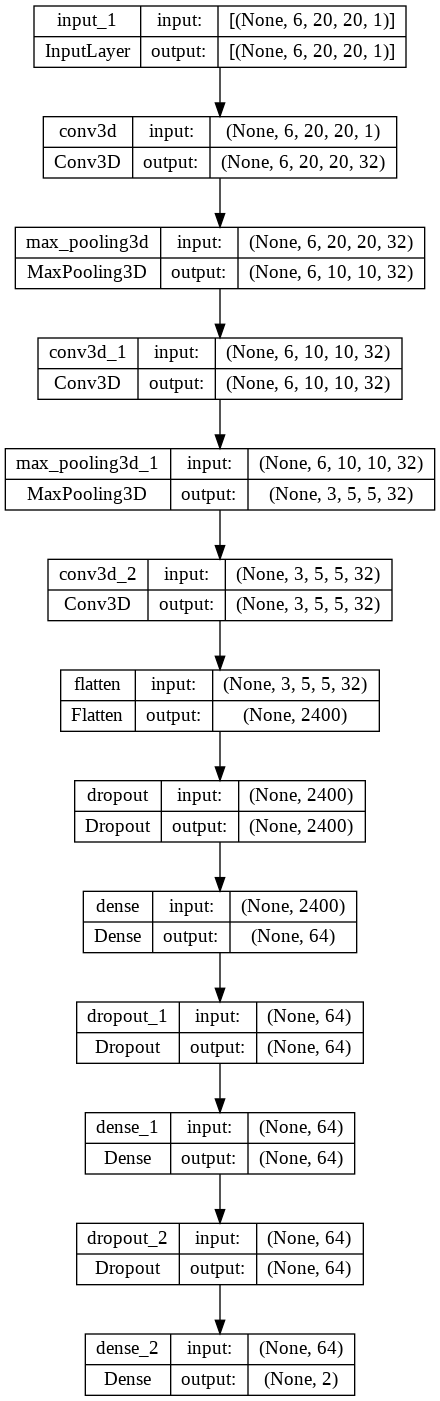

In [ ]:
plot_model(model1,show_shapes=True, show_layer_names=True)

**MODEL 2**

In [ ]:
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#sgd=optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model2.compile(
    loss= custom_crossentropy(bce),
    optimizer=adam,
    metrics=['acc',f1score,precision, recall]
)


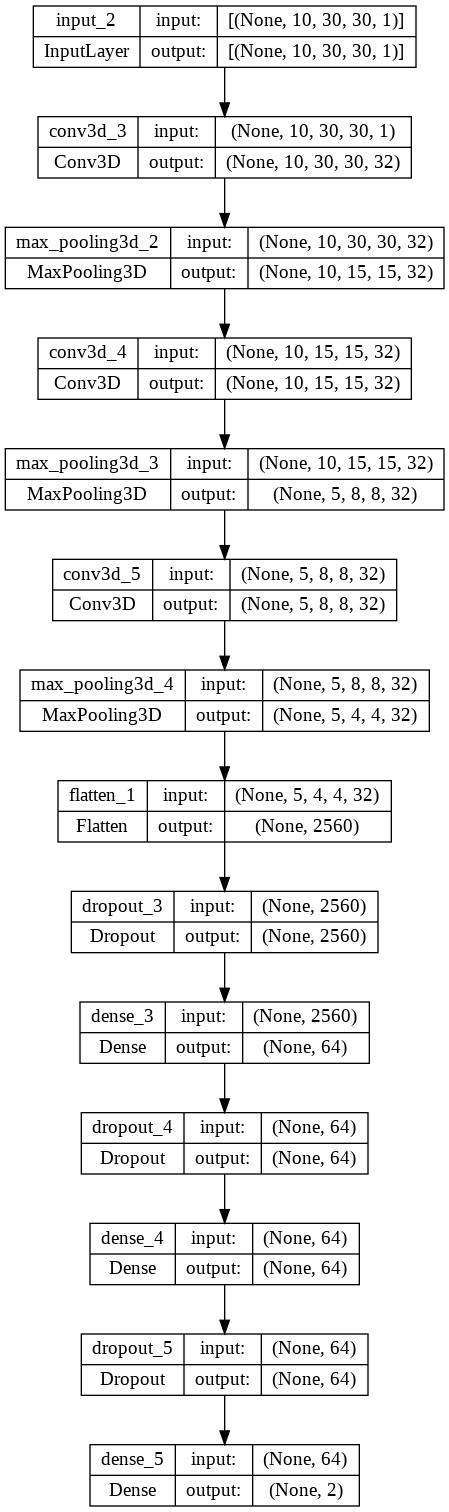

In [ ]:
plot_model(model2,show_shapes=True, show_layer_names=True)

**MODEL 3**

In [ ]:
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#sgd=optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model3.compile(
    loss= custom_crossentropy(bce),
    optimizer=adam,
    metrics=['acc',f1score,precision, recall]
)

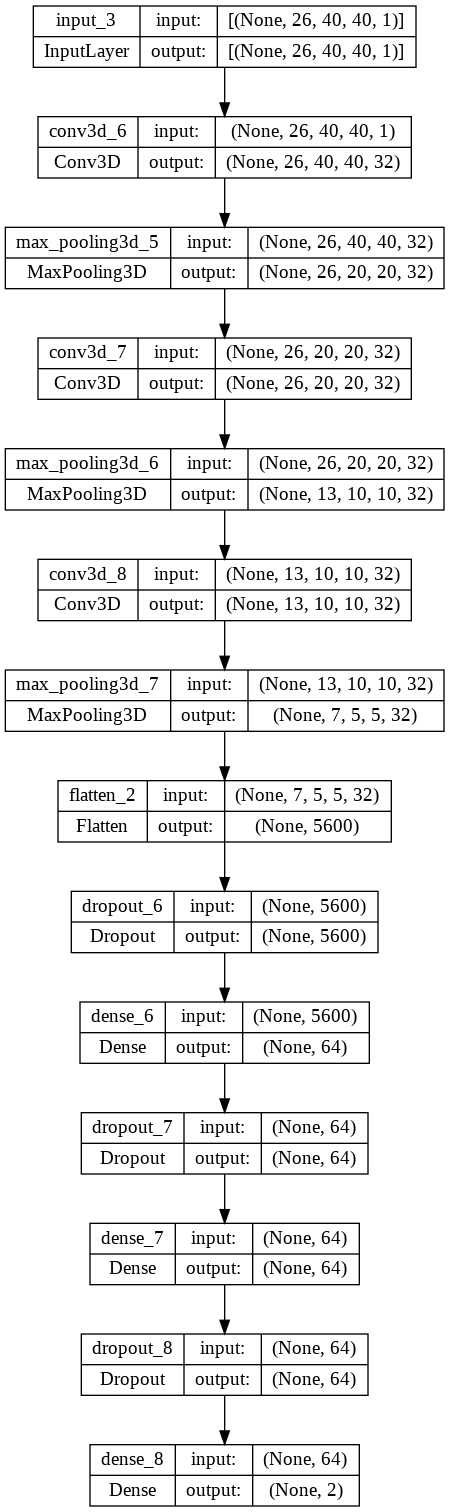

In [ ]:
plot_model(model3,show_shapes=True, show_layer_names=True)

#**Checkpoints definition MODEL1**

In [ ]:
earlystop_patience = 10 # 
earlystopper = EarlyStopping(patience=earlystop_patience, verbose=1)

In [ ]:
CALLBACKS_FOLDER =  os.path.join(root, 'ARCH_1_no_res')
os.makedirs(CALLBACKS_FOLDER, exist_ok=True)


In [ ]:
# Example of chechpointer based on values of F1-score in the validation set 
checkpointer_val_f1score = ModelCheckpoint(filepath=CALLBACKS_FOLDER + "/best_max_val_f1score_no_res.h5",
                                          monitor='val_f1score',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='max',
                                          period=1)


#**CHECKPOINTS DEFINITION MODEL2**

In [ ]:
earlystop_patience = 10 
earlystopper2 = EarlyStopping(patience=earlystop_patience, verbose=1)

In [ ]:
CALLBACKS_FOLDER2 =  os.path.join(root, 'ARCH_2_no_res')
os.makedirs(CALLBACKS_FOLDER2, exist_ok=True)

In [ ]:
# Example of chechpointer based on values of F1-score in the validation set 
checkpointer_val_f1score2 = ModelCheckpoint(filepath=CALLBACKS_FOLDER2 + "/best_max_val_f1score_no_res.h5",
                                          monitor='val_f1score',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='max',
                                          period=1)


#**CHECKPOINTS DEFINITION MODEL 3**

In [ ]:
earlystop_patience = 10 
earlystopper3 = EarlyStopping(patience=earlystop_patience, verbose=1)

In [ ]:
CALLBACKS_FOLDER3 =  os.path.join(root, 'ARCH_3_no_res')
os.makedirs(CALLBACKS_FOLDER3, exist_ok=True)

In [ ]:
# Example of chechpointer based on values of F1-score in the validation set 
checkpointer_val_f1score3 = ModelCheckpoint(filepath=CALLBACKS_FOLDER3 + "/best_max_val_f1score_no_res.h5",
                                          monitor='val_f1score',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='max',
                                          period=1)


#**Models Training**

In [ ]:
history1 = model1.fit(x = training_generator, # give the generator as input data
          validation_data = (val_images,val_labels), # give directly all images and labels for the validation set. 
          epochs = 30, steps_per_epoch = steps,
          callbacks =[earlystopper,checkpointer_val_f1score], # multiple checkpointer can be considered
          verbose =1)

(6126, 2)
 array([[ 256,    0],
       [ 257,    0],
       [ 259,    0],
       ...,
       [7126,  270],
       [7129,  270],
       [7148,  180]])
Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 98.6197 - acc: 0.6018 - f1score: 0.5369 - precision: 0.6502 - recall: 0.4997
Epoch 1: val_f1score improved from -inf to 0.38993, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_1_no_res/best_max_val_f1score_no_res.h5
40/40 [==============================] - 22s 360ms/step - loss: 98.6197 - acc: 0.6018 - f1score: 0.5369 - precision: 0.6502 - recall: 0.4997 - val_loss: 17.6631 - val_acc: 0.6798 - val_f1score: 0.3899 - val_precision: 0.2932 - val_recall: 0.7614
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 70.4421 - acc: 0.8053 - f1score: 0.8040 - precision: 0.8268 - recall: 0.8032
Epoch 2: val_f1score improved from 0.38993 to 0.51573, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_1_no_res/best_max_val_f1score_no_res.h5
40/

In [ ]:
history2 = model2.fit(x = training_generator2, # give the generator as input data
          validation_data = (val_images2,val_labels), # give directly all images and labels for the validation set. 
          epochs = 30, steps_per_epoch = steps,
          callbacks =[earlystopper2,checkpointer_val_f1score2], # multiple checkpointer can be considered
          verbose =1)

(6126, 2)
 array([[6726,    0],
       [6369,  180],
       [3167,    0],
       ...,
       [7121,  270],
       [5899,  180],
       [4734,   90]])
Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 97.6390 - acc: 0.6208 - f1score: 0.4898 - precision: 0.6656 - recall: 0.4552
Epoch 1: val_f1score improved from -inf to 0.20947, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_2_no_res/best_max_val_f1score_no_res.h5
40/40 [==============================] - 14s 328ms/step - loss: 97.6390 - acc: 0.6208 - f1score: 0.4898 - precision: 0.6656 - recall: 0.4552 - val_loss: 15.6405 - val_acc: 0.7211 - val_f1score: 0.2095 - val_precision: 0.1973 - val_recall: 0.2782
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 69.8418 - acc: 0.7823 - f1score: 0.7777 - precision: 0.8093 - recall: 0.7604
Epoch 2: val_f1score improved from 0.20947 to 0.36761, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_2_no_res/best_max_val_f1score_no_res.h5
40/

In [ ]:
history3 = model3.fit(x = training_generator3, # give the generator as input data
          validation_data = (val_images3,val_labels), # give directly all images and labels for the validation set. 
          epochs = 30, steps_per_epoch = steps,
          callbacks =[earlystopper3,checkpointer_val_f1score3], # multiple checkpointer can be considered
          verbose =1)

(6126, 2)
 array([[2211,  270],
       [2401,  270],
       [3440,    0],
       ...,
       [3682,  180],
       [ 327,    0],
       [2603,    0]])
Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 97.7488 - acc: 0.5913 - f1score: 0.4119 - precision: 0.6415 - recall: 0.3679
Epoch 1: val_f1score improved from -inf to 0.38931, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_3_no_res/best_max_val_f1score_no_res.h5
40/40 [==============================] - 39s 910ms/step - loss: 97.7488 - acc: 0.5913 - f1score: 0.4119 - precision: 0.6415 - recall: 0.3679 - val_loss: 20.5880 - val_acc: 0.6398 - val_f1score: 0.3893 - val_precision: 0.2805 - val_recall: 0.8365
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 76.3033 - acc: 0.7577 - f1score: 0.7661 - precision: 0.7641 - recall: 0.7857
Epoch 2: val_f1score improved from 0.38931 to 0.46581, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_3_no_res/best_max_val_f1score_no_res.h5
40/

##**Results**
### For the entire set of monitored metrics we can check the trend during training

**MODEL 1**

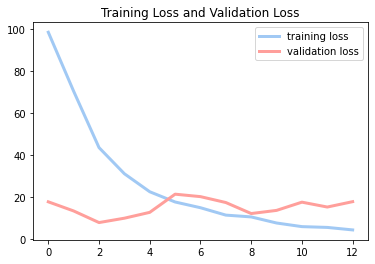

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training Loss and Validation Loss')

plt.plot(history1.history['loss'], color=sns.color_palette('pastel')[0], label="training loss", linewidth=3)
plt.plot(history1.history['val_loss'],color=sns.color_palette('pastel')[3], label="validation loss", linewidth=3)
plt.legend()
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'Loss_model1'))

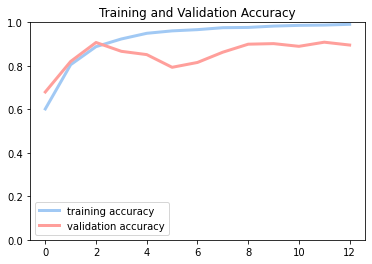

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation Accuracy')
plt.plot(history1.history['acc'],color=sns.color_palette('pastel')[0], linewidth=3, label="training accuracy")
plt.plot(history1.history['val_acc'],color=sns.color_palette('pastel')[3],linewidth=3, label="validation accuracy")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'Acc_model1'))

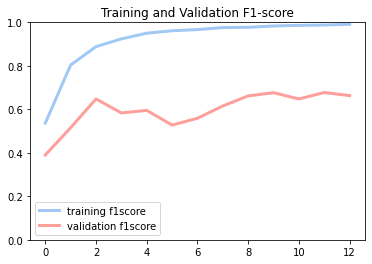

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation F1-score')
plt.plot(history1.history['f1score'], color=sns.color_palette('pastel')[0], linewidth=3,label="training f1score")
plt.plot(history1.history['val_f1score'],color=sns.color_palette('pastel')[3], linewidth=3,label="validation f1score")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'f1score_PERM_UNDER1'))

In [ ]:
print(np.max(history1.history['f1score']))

0.9911276698112488


**MODEL 2**

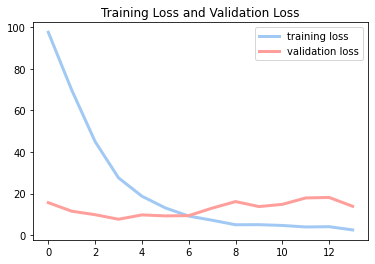

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training Loss and Validation Loss')

plt.plot(history2.history['loss'], color=sns.color_palette('pastel')[0], linewidth=3,label="training loss")
plt.plot(history2.history['val_loss'],color=sns.color_palette('pastel')[3], linewidth=3,label="validation loss")
plt.legend()
fig.savefig(os.path.join(CALLBACKS_FOLDER2, 'Loss_model2'))

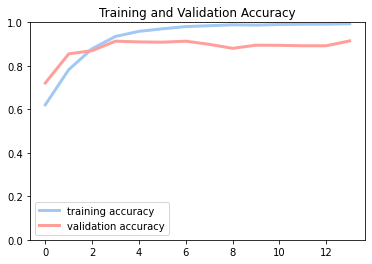

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation Accuracy')
plt.plot(history2.history['acc'], color=sns.color_palette('pastel')[0], linewidth=3,label="training accuracy")
plt.plot(history2.history['val_acc'],color=sns.color_palette('pastel')[3], linewidth=3,label="validation accuracy")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER2, 'Acc_model2'))

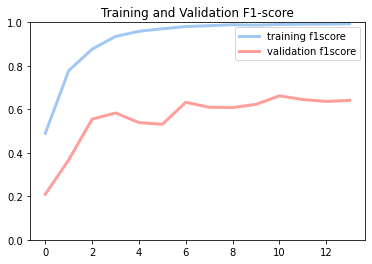

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation F1-score')
plt.plot(history2.history['f1score'], color=sns.color_palette('pastel')[0], linewidth=3,label="training f1score")
plt.plot(history2.history['val_f1score'], color=sns.color_palette('pastel')[3], linewidth=3, label="validation f1score")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER2, 'f1score_PERM_UNDER2'))

In [ ]:
print(np.max(history2.history['f1score']))

0.9935723543167114


**MODEL 3**

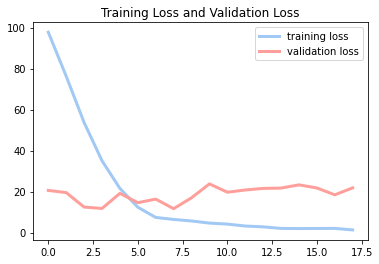

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training Loss and Validation Loss')

plt.plot(history3.history['loss'], color=sns.color_palette('pastel')[0], linewidth=3,label="training loss")
plt.plot(history3.history['val_loss'], color=sns.color_palette('pastel')[3], linewidth=3,label="validation loss")
plt.legend()
fig.savefig(os.path.join(CALLBACKS_FOLDER3, 'Loss_model3'))

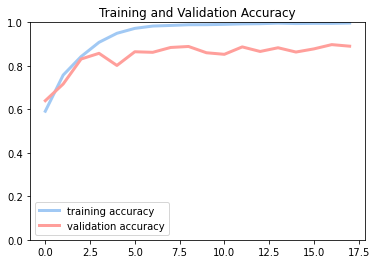

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation Accuracy')
plt.plot(history3.history['acc'], color=sns.color_palette('pastel')[0], linewidth=3,label="training accuracy")
plt.plot(history3.history['val_acc'], color=sns.color_palette('pastel')[3], linewidth=3,label="validation accuracy")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER3, 'Acc_model3'))

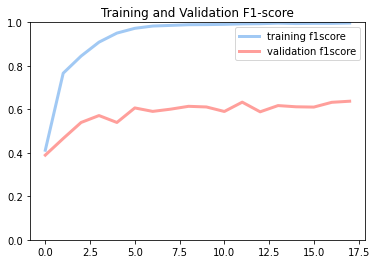

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation F1-score')
plt.plot(history3.history['f1score'], color=sns.color_palette('pastel')[0], linewidth=3,label="training f1score")
plt.plot(history3.history['val_f1score'], color=sns.color_palette('pastel')[3], linewidth=3,label="validation f1score")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER3, 'f1score_PERM_UNDER3'))

In [ ]:
print(np.max(history3.history['f1score']))

0.9968515634536743


#**Model restoring**

In [ ]:
arch1_restored = load_model(root + "/ARCH_1_no_res/best_max_val_f1score_no_res.h5",compile=False)
arch2_restored = load_model(root + "/ARCH_2_no_res/best_max_val_f1score_no_res.h5",compile=False)
arch3_restored = load_model(root + "/ARCH_3_no_res/best_max_val_f1score_no_res.h5",compile=False)

###Make the prediction on the validation dataset

In [ ]:
# PREDICTION of THE CLASSIFICATION PROBABILITIES NEEDED TO CONSTRUCT THE FEATURES MATRIX FOR THE TRAINING SET
y_pred_val = arch1_restored.predict(val_images)
y_pred_val2 = arch2_restored.predict(val_images2)
y_pred_val3 = arch3_restored.predict(val_images3)

print(y_pred_val3)
y_pred_val = np.asarray(y_pred_val)[:,0]
y_pred_val2 = np.asarray(y_pred_val2)[:,0]
y_pred_val3 = np.asarray(y_pred_val3)[:,0]

print(np.shape(y_pred_val))
print(np.shape(y_pred_val2))
print(np.shape(y_pred_val3))

48/48 [==============================] - 1s 23ms/step
[[1.1340906e-05 9.9998868e-01]
 [5.4910547e-06 9.9999452e-01]
 [4.2503618e-08 1.0000000e+00]
 ...
 [9.9993026e-01 6.9698210e-05]
 [9.9973172e-01 2.6830015e-04]
 [1.0000000e+00 6.0542044e-33]]
(1524,)
(1524,)
(1524,)


In [ ]:
print(np.shape(val_labels))
val_target = np.asarray(val_labels)[:,0]
np.shape(val_target)

(1524, 2)


(1524,)

# Metrics calculation and results visualization

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_curve,auc,roc_curve, precision_score, recall_score
import seaborn as sn

**MODEL 1**

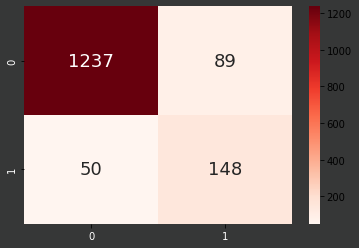

In [ ]:
selected_thr = 0.5

# Confusion Matrix
CM = confusion_matrix(val_target,y_pred_val>=selected_thr)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Reds) # font size
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix.png'), facecolor=fig.get_facecolor() )

In [ ]:
tn, fp, fn, tp = confusion_matrix(val_target,y_pred_val>=selected_thr).ravel()
print(tn)
print(fp)
print(fn)
print(tp)
Se = round(tp/(tp+fn),2) # Recall (Sensitivity)
Pr = round(tp/(tp+fp),2) # Precision
print("(Se,Pr)=("+str(Se)+","+str(Pr)+")")

1237
89
50
148
(Se,Pr)=(0.75,0.62)


In [ ]:
#Accuracy
acc = accuracy_score(val_target,y_pred_val>=selected_thr)
acc

0.9087926509186351

**MODEL 2**

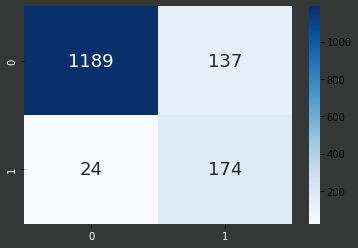

In [ ]:
selected_thr = 0.5

# Confusion Matrix
CM = confusion_matrix(val_target,y_pred_val2>=selected_thr)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Blues) 
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix.png'), facecolor=fig.get_facecolor() )

In [ ]:
tn, fp, fn, tp = confusion_matrix(val_target,y_pred_val2>=selected_thr).ravel()
print(tn)
print(fp)
print(fn)
print(tp)
Se = round(tp/(tp+fn),2) # Recall (Sensitivity)
Pr = round(tp/(tp+fp),2) # Precision
print("(Se,Pr)=("+str(Se)+","+str(Pr)+")")

1189
137
24
174
(Se,Pr)=(0.88,0.56)


In [ ]:
#Accuracy
acc = accuracy_score(val_target,y_pred_val2>=selected_thr)
acc

0.8943569553805775

**MODEL 3**

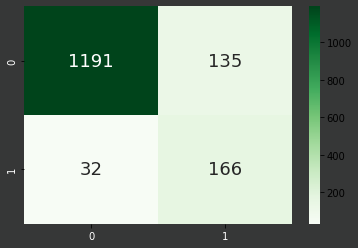

In [ ]:
selected_thr = 0.5

# Confusion Matrix
CM = confusion_matrix(val_target,y_pred_val3>=selected_thr)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Greens) # font size
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix.png'), facecolor=fig.get_facecolor() )

In [ ]:
tn, fp, fn, tp = confusion_matrix(val_target,y_pred_val3>=selected_thr).ravel()
print(tn)
print(fp)
print(fn)
print(tp)
Se = round(tp/(tp+fn),2) # Recall (Sensitivity)
Pr = round(tp/(tp+fp),2) # Precision
print("(Se,Pr)=("+str(Se)+","+str(Pr)+")")

1191
135
32
166
(Se,Pr)=(0.84,0.55)


In [ ]:
#Accuracy
acc = accuracy_score(val_target,y_pred_val3>=selected_thr)
acc

0.8904199475065617

###PRC and ROC curve

**Model 1**

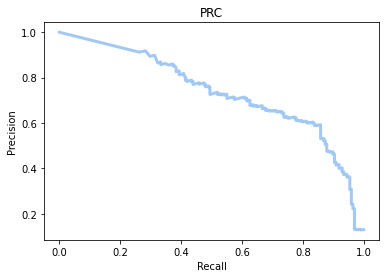

AUPRC TEST-SET : 0.74


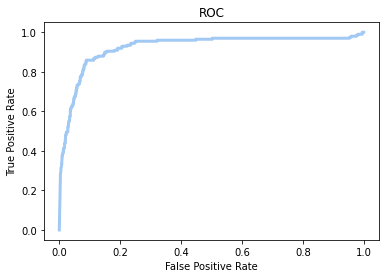

AUROC: 0.92


In [ ]:
# Compute PRC
prec, rec, thr_auprc=precision_recall_curve(val_target,y_pred_val)
fig, ax = plt.subplots()
plt.plot(rec,prec,color=sns.color_palette('pastel')[0], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'PRC_NO_RES'))
print("AUPRC TEST-SET : "+str(round(auc(rec,prec),2)))

# Compute ROC
fpr, tpr, thr_auc=roc_curve(val_target,y_pred_val)
fig, ax = plt.subplots()
plt.plot(fpr,tpr,color=sns.color_palette('pastel')[0], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'AUROC_NO_RES'))
print('AUROC: '+ str(round(auc(fpr,tpr),2)))


In [ ]:
from keras.engine.training import h5py

In [ ]:
#saving the data value in a file
with h5py.File(os.path.join(CALLBACKS_FOLDER, 'Data_NO_RES_CORRECT.hdf5'), 'w') as f:
    f.create_dataset('accuracy', data=acc)
    f.create_dataset('prec', data=prec)
    f.create_dataset('rec', data=rec)
    f.create_dataset('thr_auprc', data=thr_auprc)
    f.create_dataset('fpr', data=fpr)
    f.create_dataset('tpr', data=tpr)
    f.create_dataset('thr_auc', data=thr_auc)
    f.close

**Model 2**

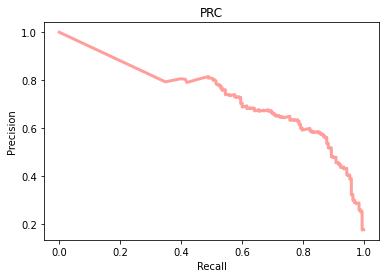

AUPRC TEST-SET : 0.74


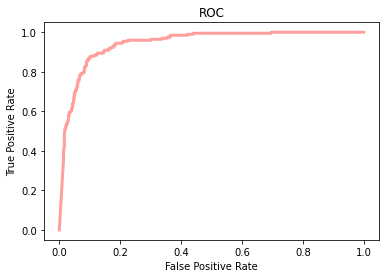

AUROC: 0.94


In [ ]:
# Compute PRC
prec, rec, thr_auprc=precision_recall_curve(val_target,y_pred_val2)
fig, ax = plt.subplots()
plt.plot(rec,prec,color=sns.color_palette('pastel')[3], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER2, 'PRC_NO_RES'))
print("AUPRC TEST-SET : "+str(round(auc(rec,prec),2)))

# Compute ROC
fpr, tpr, thr_auc=roc_curve(val_target,y_pred_val2)
fig, ax = plt.subplots()
plt.plot(fpr,tpr,color=sns.color_palette('pastel')[3], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER2, 'AUROC_NO_RES'))
print('AUROC: '+ str(round(auc(fpr,tpr),2)))

In [ ]:
#saving the data value in a file
with h5py.File(os.path.join(CALLBACKS_FOLDER2, 'Data_NO_RES_CORRECT.hdf5'), 'w') as f:
    f.create_dataset('accuracy', data=acc)
    f.create_dataset('prec', data=prec)
    f.create_dataset('rec', data=rec)
    f.create_dataset('thr_auprc', data=thr_auprc)
    f.create_dataset('fpr', data=fpr)
    f.create_dataset('tpr', data=tpr)
    f.create_dataset('thr_auc', data=thr_auc)
    f.close

**Model 3**

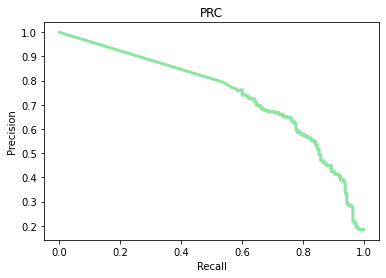

AUPRC TEST-SET : 0.75


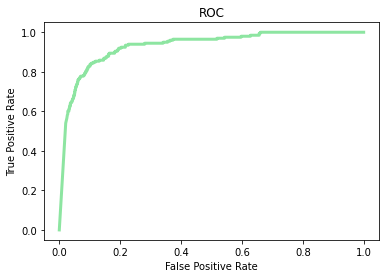

AUROC: 0.93


In [ ]:
# Compute PRC
prec, rec, thr_auprc=precision_recall_curve(val_target,y_pred_val3)
fig, ax = plt.subplots()
plt.plot(rec,prec,color=sns.color_palette('pastel')[2], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER3, 'PRC_NO_RES'))
print("AUPRC TEST-SET : "+str(round(auc(rec,prec),2)))

# Compute ROC
fpr, tpr, thr_auc=roc_curve(val_target,y_pred_val3)
fig, ax = plt.subplots()
plt.plot(fpr,tpr,color=sns.color_palette('pastel')[2], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER3, 'AUROC_NO_RES'))
print('AUROC: '+ str(round(auc(fpr,tpr),2)))

In [ ]:
#saving the data value in a file
with h5py.File(os.path.join(CALLBACKS_FOLDER3, 'Data_NO_RES_CORRECT.hdf5'), 'w') as f:
    f.create_dataset('accuracy', data=acc)
    f.create_dataset('prec', data=prec)
    f.create_dataset('rec', data=rec)
    f.create_dataset('thr_auprc', data=thr_auprc)
    f.create_dataset('fpr', data=fpr)
    f.create_dataset('tpr', data=tpr)
    f.create_dataset('thr_auc', data=thr_auc)
    f.close

# MODELS COMBINATION as Dou et al.

In [ ]:
#TRAIN
#labels vector
y_train = y[list(idx_train),0]
# branch 1 image
trainREG_ARCH1_images = np.expand_dims(h5file.root.images[list(idx_train),10:16,10:30,10:30],axis=-1)
trainREG_ARCH1_images = normalize(trainREG_ARCH1_images)
#branch 2 image
trainREG_ARCH2_images = np.expand_dims(h5file.root.images[list(idx_train),10:20,10:40,10:40],axis=-1)
trainREG_ARCH2_images = normalize(trainREG_ARCH2_images)
#branch 3 image
trainREG_ARCH3_images = np.expand_dims(h5file.root.images[list(idx_train),0:26,0:40,0:40],axis=-1)
trainREG_ARCH3_images = normalize(trainREG_ARCH3_images)

# PREDICT PROBABILITIES WITH THE RESTORED MODELS ON TRAIN SET
#branch 1 probabilities 
y_pred_arch1_train = arch1_restored.predict(trainREG_ARCH1_images)
#branch 2 probabilities 
y_pred_arch2_train = arch2_restored.predict(trainREG_ARCH2_images)
#branch 3 probabilities 
y_pred_arch3_train = arch3_restored.predict(trainREG_ARCH3_images)

114/114 [==============================] - 3s 23ms/step


In [ ]:
#VALIDATION
y_val = y[list(idx_val),0]
y_pred_arch1_val = arch1_restored.predict(val_images)
#branch 2 probabilities 
y_pred_arch2_val = arch2_restored.predict(val_images2)
#branch 3 probabilities 
y_pred_arch3_val = arch3_restored.predict(val_images3)

48/48 [==============================] - 1s 23ms/step


In [ ]:
#TEST
y_test = y[list(idx_test),0]
# branch 1 image
testREG_ARCH1_images = np.expand_dims(h5file.root.images[list(idx_test),10:16,10:30,10:30],axis=-1)
testREG_ARCH1_images = normalize(testREG_ARCH1_images)
#branch 2 image
testREG_ARCH2_images = np.expand_dims(h5file.root.images[list(idx_test),10:20,10:40,10:40],axis=-1)
testREG_ARCH2_images = normalize(testREG_ARCH2_images)
#branch 3 image
testREG_ARCH3_images = np.expand_dims(h5file.root.images[list(idx_test),0:26,0:40,0:40],axis=-1)
testREG_ARCH3_images = normalize(testREG_ARCH3_images)


#PREDICTION ON TEST SET

y_pred_arch1_test = arch1_restored.predict(testREG_ARCH1_images)
#branch 2 probabilities 
y_pred_arch2_test = arch2_restored.predict(testREG_ARCH2_images)
#branch 3 probabilities 
y_pred_arch3_test = arch3_restored.predict(testREG_ARCH3_images)

63/63 [==============================] - 2s 25ms/step


In [ ]:
y_pred_arch1_train = y_pred_arch1_train[:,0]
y_pred_arch2_train = y_pred_arch2_train[:,0]
y_pred_arch3_train = y_pred_arch3_train[:,0]
y_pred_arch1_val = y_pred_arch1_val[:,0]
y_pred_arch2_val = y_pred_arch2_val[:,0]
y_pred_arch3_val = y_pred_arch3_val[:,0]
y_pred_arch1_test = y_pred_arch1_test[:,0]
y_pred_arch2_test = y_pred_arch2_test[:,0]
y_pred_arch3_test = y_pred_arch3_test[:,0]

In [ ]:
y_pred_arch1_train[y_pred_arch1_train>=0.5] = 1
y_pred_arch1_train[y_pred_arch1_train<0.5] = 0
y_pred_arch2_train[y_pred_arch2_train>=0.5] = 1
y_pred_arch2_train[y_pred_arch2_train<0.5] = 0
y_pred_arch3_train[y_pred_arch3_train>=0.5] = 1
y_pred_arch3_train[y_pred_arch3_train<0.5] = 0
y_pred_arch1_val[y_pred_arch1_val>=0.5] = 1
y_pred_arch1_val[y_pred_arch1_val<0.5] = 0
y_pred_arch2_val[y_pred_arch2_val>=0.5] = 1
y_pred_arch2_val[y_pred_arch2_val<0.5] = 0
y_pred_arch3_val[y_pred_arch3_val>=0.5] = 1
y_pred_arch3_val[y_pred_arch3_val<0.5] = 0
y_pred_arch1_test[y_pred_arch1_test>=0.5] = 1
y_pred_arch1_test[y_pred_arch1_test<0.5] = 0
y_pred_arch2_test[y_pred_arch2_test>=0.5] = 1
y_pred_arch2_test[y_pred_arch2_test<0.5] = 0
y_pred_arch3_test[y_pred_arch3_test>=0.5] = 1
y_pred_arch3_test[y_pred_arch3_test<0.5] = 0

In [ ]:
#define the grid of weights to be investigated
values_grid = np.arange(0.01, 0.99, 0.01);
def prediction_from_array (y1, y2, y3, a, b, c):
  lista =[]
  for i in range (len(y1)):
    h = a*y1[i] + b*y2[i] + c*y3[i]
    if h >= 0.5:
      h=1
    else:
      h=0
    lista.append(h)
  return lista

In [ ]:
#TRAIN
best_train = [0, 0, 0]
area_max = 0
for a in values_grid:
  for b in values_grid:
    for c in values_grid:
      if(a+b+c == 1):
        y_pred = prediction_from_array(y_pred_arch1_train,y_pred_arch2_train,y_pred_arch3_train, a, b, c);
        y_pred = np.asarray(y_pred)
        prec, rec, thr_auprc=precision_recall_curve(y_train,y_pred)
        fpr, tpr, thr_auc=roc_curve(y_train,y_pred)
        auprc = auc(rec,prec)
        auroc = auc(fpr,tpr)
        if(auprc > area_max):
          area_max = auprc
          best_train[0] = a
          best_train[1] = b
          best_train[2] = c

print(best_train)

[0.01, 0.01, 0.98]


In [ ]:
#VALIDATION
best_val = [0, 0, 0]
area_max = 0
for a in values_grid:
  for b in values_grid:
    for c in values_grid:
      if(a+b+c == 1):
        y_pred = prediction_from_array(y_pred_arch1_val,y_pred_arch2_val,y_pred_arch3_val, a, b, c);
        y_pred = np.asarray(y_pred)
        prec, rec, thr_auprc=precision_recall_curve(y_val,y_pred)
        fpr, tpr, thr_auc=roc_curve(y_val,y_pred)
        auprc = auc(rec,prec)
        auroc = auc(fpr,tpr)
        if(auprc > area_max):
          area_max = auprc
          best_val[0] = a
          best_val[1] = b
          best_val[2] = c

print(best_val)

[0.02, 0.49, 0.49]


In [ ]:
#TEST
best_test = [0, 0, 0]
area_max = 0
for a in values_grid:
  for b in values_grid:
    for c in values_grid:
      if(a+b+c == 1):
        y_pred = prediction_from_array(y_pred_arch1_test, y_pred_arch2_test,y_pred_arch3_test, a, b, c);
        y_pred = np.asarray(y_pred)
        prec, rec, thr_auprc=precision_recall_curve(y_test,y_pred)
        fpr, tpr, thr_auc=roc_curve(y_test,y_pred)
        auprc = auc(rec,prec)
        auroc = auc(fpr,tpr)
        if(auprc > area_max):
          area_max = auprc
          best_test[0] = a
          best_test[1] = b
          best_test[2] = c

print(best_test)

[0.5, 0.01, 0.49]


In [ ]:
y_pred_multibranch_train = prediction_from_array(y_pred_arch1_train,y_pred_arch2_train,y_pred_arch3_train, best_train[0], best_train[1], best_train[2])
y_pred_multibranch_train = np.asarray(y_pred_multibranch_train)
y_pred_multibranch_val= prediction_from_array(y_pred_arch1_val,y_pred_arch2_val,y_pred_arch3_val,best_val[0], best_val[1], best_val[2])
y_pred_multibranch_val = np.asarray(y_pred_multibranch_val)
y_pred_multibranch_test= prediction_from_array(y_pred_arch1_test,y_pred_arch2_test,y_pred_arch3_test, best_test[0], best_test[1], best_test[2])
y_pred_multibranch_test = np.asarray(y_pred_multibranch_test)

In [ ]:
CALLBACKS_FOLDER_MULTI = os.path.join(root, 'ARCH_MULTIBRANCH')
os.makedirs(CALLBACKS_FOLDER_MULTI, exist_ok=True)

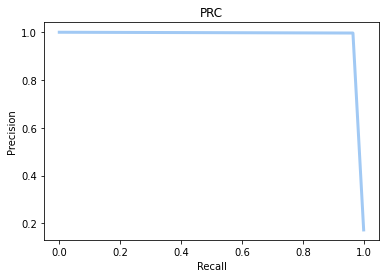

AUPRC TEST-SET : 0.98


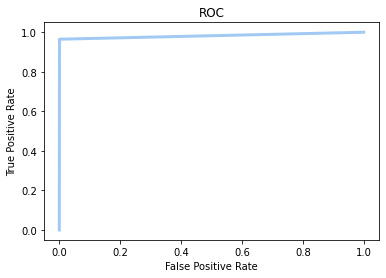

AUROC: 0.98


In [ ]:
#TRAIN
# Compute PRC
prec, rec, thr_auprc=precision_recall_curve(y_train,y_pred_multibranch_train)
fig, ax = plt.subplots()
plt.plot(rec,prec,color=sns.color_palette('pastel')[0], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER_MULTI, 'PRC_NO_RES_TRAIN'))
print("AUPRC TEST-SET : "+str(round(auc(rec,prec),2)))

# Compute ROC
fpr, tpr, thr_auc=roc_curve(y_train,y_pred_multibranch_train)
fig, ax = plt.subplots()
plt.plot(fpr,tpr,color=sns.color_palette('pastel')[0], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER_MULTI, 'AUROC_NO_RES_TRAIN'))
print('AUROC: '+ str(round(auc(fpr,tpr),2)))

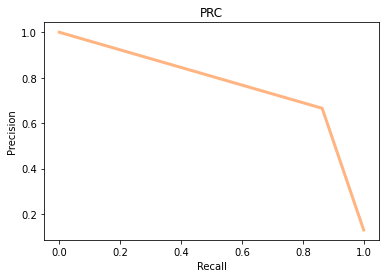

AUPRC VALIDATION-SET : 0.77


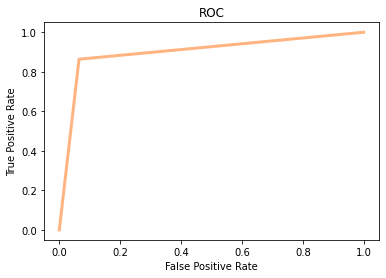

AUROC: 0.9


In [ ]:
#VALIDATION
# Compute PRC
prec, rec, thr_auprc=precision_recall_curve(y_val,y_pred_multibranch_val)
fig, ax = plt.subplots()
plt.plot(rec,prec,color=sns.color_palette('pastel')[1], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER_MULTI, 'PRC_NO_RES_VAL'))
print("AUPRC VALIDATION-SET : "+str(round(auc(rec,prec),2)))

# Compute ROC
fpr, tpr, thr_auc=roc_curve(y_val,y_pred_multibranch_val)
fig, ax = plt.subplots()
plt.plot(fpr,tpr,color=sns.color_palette('pastel')[1], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER_MULTI, 'AUROC_NO_RES_VAL'))
print('AUROC: '+ str(round(auc(fpr,tpr),2)))

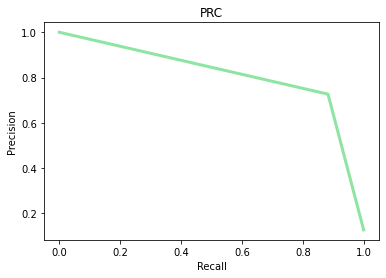

AUPRC TEST-SET : 0.81


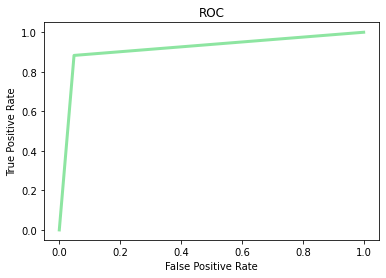

AUROC: 0.92


In [ ]:
#TEST
# Compute PRC
prec_test, rec_test, thr_auprc_test=precision_recall_curve(y_test,y_pred_multibranch_test)
fig, ax = plt.subplots()
plt.plot(rec_test,prec_test,color=sns.color_palette('pastel')[2], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER_MULTI, 'PRC_NO_RES_TEST'))
print("AUPRC TEST-SET : "+str(round(auc(rec_test,prec_test),2)))

# Compute ROC
fpr_test, tpr_test, thr_auc_test=roc_curve(y_test,y_pred_multibranch_test)
fig, ax = plt.subplots()
plt.plot(fpr_test,tpr_test,color=sns.color_palette('pastel')[2], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER_MULTI, 'AUROC_NO_RES_TEST'))
print('AUROC: '+ str(round(auc(fpr_test,tpr_test),2)))

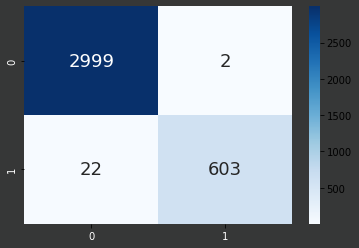

In [ ]:
#TRAINING
# Confusion Matrix
CM = confusion_matrix(y_train,y_pred_multibranch_train)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Blues) # font size
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix_train_multi.png'), facecolor=fig.get_facecolor() )

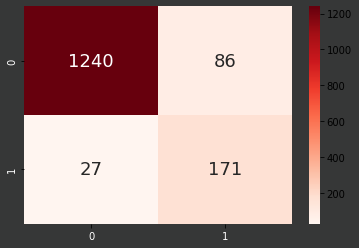

In [ ]:
#VALIDATION
# Confusion Matrix
CM = confusion_matrix(y_val,y_pred_multibranch_val)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Reds) # font size
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix_val_multi.png'), facecolor=fig.get_facecolor() )

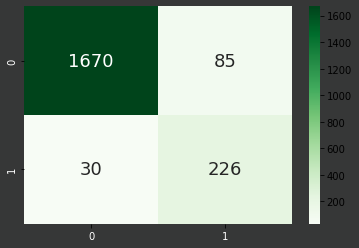

In [ ]:
#TEST
# Confusion Matrix
CM = confusion_matrix(y_test,y_pred_multibranch_test)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Greens) # font size
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix_test_multi.png'), facecolor=fig.get_facecolor() )

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
#ACCURACY of different models ON TEST SET
acc_model1 = accuracy_score(y_test,y_pred_arch1_test>=selected_thr)
acc_model2 = accuracy_score(y_test,y_pred_arch2_test>=selected_thr)
acc_model3 = accuracy_score(y_test,y_pred_arch3_test>=selected_thr)
print("Accuracy Model 1:       {}".format(acc_model1))
print("Accuracy Model 2:       {}".format(acc_model2))
print("Accuracy Model 3:       {}".format(acc_model3))

Accuracy Model 1:       0.9363500745897564
Accuracy Model 2:       0.8881153654898061
Accuracy Model 3:       0.9224266534062655


In [ ]:
#ACCURACY of different models ON VALIDATION SET
acc_model1 = accuracy_score(val_target,y_pred_val>=selected_thr)
acc_model2 = accuracy_score(val_target,y_pred_val2>=selected_thr)
acc_model3 = accuracy_score(val_target,y_pred_val3>=selected_thr)
print("Accuracy Model 1:       {}".format(acc_model1))
print("Accuracy Model 2:       {}".format(acc_model2))
print("Accuracy Model 3:       {}".format(acc_model3))

Accuracy Model 1:       0.9087926509186351
Accuracy Model 2:       0.8943569553805775
Accuracy Model 3:       0.8904199475065617


In [ ]:
#ACCURACY of multibranch
acc_train = accuracy_score(y_train,y_pred_multibranch_train)
acc_val  =  accuracy_score(y_val,  y_pred_multibranch_val)
acc_test =  accuracy_score(y_test, y_pred_multibranch_test)
print("Accuracy on train set:      {}".format(acc_train))
print("Accuracy on validation:     {}".format(acc_val))
print("Accuracy on test set:       {}".format(acc_test))

Accuracy on train set:      0.9933811362382791
Accuracy on validation:     0.9258530183727034
Accuracy on test set:       0.9428145201392342


In [ ]:
#f1 scores of different models TEST
f1_model1 = f1_score(y_test,y_pred_arch1_test>=selected_thr)
f1_model2 =  f1_score(y_test,y_pred_arch2_test>=selected_thr)
f1_model3 = f1_score(y_test,y_pred_arch3_test>=selected_thr)
print("F1 Model 1:        {}".format(f1_model1))
print("F1 Model 2:        {}".format(f1_model3))
print("F1 Model 3:        {}".format(f1_model3))

F1 Model 1:        0.7480314960629921
F1 Model 2:        0.7282229965156795
F1 Model 3:        0.7282229965156795


In [ ]:
#f1 scores of different models
f1_model1 = f1_score(val_target,y_pred_val>=selected_thr)
f1_model2 =  f1_score(val_target,y_pred_val2>=selected_thr)
f1_model3 = f1_score(val_target,y_pred_val3>=selected_thr)
print("F1 Model 1:        {}".format(f1_model1))
print("F1 Model 2:        {}".format(f1_model3))
print("F1 Model 3:        {}".format(f1_model3))

F1 Model 1:        0.6804597701149426
F1 Model 2:        0.6653306613226453
F1 Model 3:        0.6653306613226453


In [ ]:
#f1 score of multibranch
f1_train = f1_score(y_train,y_pred_multibranch_train)
f1_val = f1_score(y_val,y_pred_multibranch_val)
f1_test = f1_score(y_test,y_pred_multibranch_test)
print("F1 on train set:      {}".format(f1_train))
print("F1 on validation:     {}".format(f1_val))
print("F1 on test set:       {}".format(f1_test))

F1 on train set:      0.9804878048780489
F1 on validation:     0.7516483516483516
F1 on test set:       0.7971781305114639


In [ ]:

#recall of different model TEST
recall_1 = recall_score(y_test,y_pred_arch1_test>=selected_thr)
recall_2 = recall_score(y_test,y_pred_arch2_test>=selected_thr)
recall_3 = recall_score(y_test,y_pred_arch3_test>=selected_thr)
print("recall on model 1:       {}".format(recall_1))
print("recall on model 2:       {}".format(recall_2))
print("recall on model 3:       {}".format(recall_3))

recall on model 1:       0.7421875
recall on model 2:       0.84765625
recall on model 3:       0.81640625


In [ ]:

#Precision of different model TEST
precision_1 = precision_score(y_test,y_pred_arch1_test>=selected_thr)
precision_2 = precision_score(y_test,y_pred_arch2_test>=selected_thr)
precision_3 = precision_score(y_test,y_pred_arch3_test>=selected_thr)
print("Precision on model 1:       {}".format(precision_1))
print("Precision on model 2:       {}".format(precision_2))
print("Precision on model 3:       {}".format(precision_3))

Precision on model 1:       0.753968253968254
Precision on model 2:       0.5384615384615384
Precision on model 3:       0.6572327044025157


In [ ]:
#recall of multibranch
recall_train = recall_score(y_train,y_pred_multibranch_train)
recall_val = recall_score(y_val,y_pred_multibranch_val)
recall_test = recall_score(y_test,y_pred_multibranch_test)
print("recall on train set:      {}".format(recall_train))
print("recall on validation:     {}".format(recall_val))
print("recall on test set:       {}".format(recall_test))

recall on train set:      0.9648
recall on validation:     0.8636363636363636
recall on test set:       0.8828125


In [ ]:
#precision of multibranch
precision_train = precision_score(y_train,y_pred_multibranch_train)
precision_val = precision_score(y_val,y_pred_multibranch_val)
precision_test = precision_score(y_test,y_pred_multibranch_test)
print("precision on train set:      {}".format(precision_train))
print("precision on validation:     {}".format(precision_val))
print("precision on test set:       {}".format(precision_test))

precision on train set:      0.996694214876033
precision on validation:     0.6653696498054474
precision on test set:       0.7266881028938906


In [ ]:
#saving the data value in a file
with h5py.File(os.path.join(CALLBACKS_FOLDER_MULTI, 'Data_NO_RES_MULTI_TEST.hdf5'), 'w') as f:
    f.create_dataset('accuracy', data=acc_test)
    f.create_dataset('prec', data=prec_test)
    f.create_dataset('rec', data=rec_test)
    f.create_dataset('thr_auprc', data=thr_auprc_test)
    f.create_dataset('fpr', data=fpr_test)
    f.create_dataset('tpr', data=tpr_test)
    f.create_dataset('thr_auc', data=thr_auc_test)
    f.create_dataset('f1_Score', data=f1_test)
    f.close